<a href="https://cognitiveclass.ai"><img src = "https://ibm.box.com/shared/static/9gegpsmnsoo25ikkbl4qzlvlyjbgxs5x.png" width = 400> </a>

<h1 align=center><font size = 5>Segmenting and Clustering Neighborhoods in New York City</font></h1>

## Introduction

In this lab, you will learn how to convert addresses into their equivalent latitude and longitude values. Also, you will use the Foursquare API to explore neighborhoods in New York City. You will use the **explore** function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. You will use the *k*-means clustering algorithm to complete this task. Finally, you will use the Folium library to visualize the neighborhoods in New York City and their emerging clusters.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Download and Explore Dataset</a>

2. <a href="#item2">Explore Neighborhoods in New York City</a>

3. <a href="#item3">Analyze Each Neighborhood</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Clusters</a>    
</font>
</div>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [5]:
# import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

## 1. Download and Explore Dataset

Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

Luckily, this dataset exists for free on the web. Feel free to try to find this dataset on your own, but here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572

For your convenience, I downloaded the files and placed it on the server, so you can simply run a `wget` command and access the data. So let's go ahead and do that.

In [6]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


#### Load and explore the data

Next, let's load the data.

In [7]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.

Notice how all the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [8]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.

#### Tranform the data into a *pandas* dataframe

The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe. So let's start by creating an empty dataframe.

In [9]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [10]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [11]:
for data in neighborhoods_data:
    borough_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough_name,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

The data to be used for the map will be the neighborhoods in the Bronx Borough
The Line of code below creates a dataframe for the neighborhoods in the bronx borough

In [ ]:
Bronx_data = neighborhoods[neighborhoods['Borough'] == 'Bronx'].reset_index(drop=True)
Bronx_data.head()

#### Define Foursquare Credentials and Version
The defined credential will enable fetching of  location data 

In [15]:
# This keys that i am inputing here are the generated client secret and id that have been provided for me by Foursquare
CLIENT_ID = 'FXCEBGKMJDFN5SGMZFYAL11BNRMYU3GTWKUOU05PEYB44SHV' 
CLIENT_SECRET = 'ABRGQYYUJQDZDV4WLADVY0MHB2Z0HB540WMY5OBY1HJG1H1K' 
VERSION = '20180605'

<a id='item2'></a>

## 2. Explore Neighborhoods in Bronx

In [32]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    LIMIT = 1000
    radius = 10000

    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [33]:
#### Now write the code to run the above function on each neighborhood and create a new dataframe called *bronx_venues*.

bronx_venues = getNearbyVenues(names=Bronx_data['Neighborhood'],
                                   latitudes=Bronx_data['Latitude'],
                                   longitudes=Bronx_data['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Claremont Village
Concourse Village
Mount Eden
Mount Hope
Bronxdale
Allerton
Kingsbridge Heights


#### Let's check the size of the resulting dataframe

In [34]:
print(bronx_venues.shape)
bronx_venues.head()

(1209, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Shell,40.894187,-73.845862,Gas Station
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


Let's check how many venues were returned for each neighborhood

#### Let's find out how many unique categories can be curated from all the returned venues

In [43]:
print('There are {} uniques categories.'.format(len(bronx_venues['Venue Category'].unique())))
bronx_venues['Venue Category'].value_counts()

There are 175 uniques categories.


Pizza Place                        95
Deli / Bodega                      55
Donut Shop                         46
Italian Restaurant                 41
Sandwich Place                     41
Pharmacy                           40
Supermarket                        38
Chinese Restaurant                 34
Bank                               34
Fast Food Restaurant               32
Spanish Restaurant                 31
Bus Station                        29
Grocery Store                      26
Mexican Restaurant                 24
Diner                              23
Park                               23
Discount Store                     19
Bakery                             18
Coffee Shop                        17
Bar                                17
Ice Cream Shop                     17
Latin American Restaurant          16
Gym                                15
Liquor Store                       15
Caribbean Restaurant               15
Fried Chicken Joint                14
American Res

##### Dropping all venues that are cofee stores
This is done because my client is trying to site a coffee store and we cannot locate a coffee store on another coffee store
I also grouped the data based on the neighborhoods
I then selected the top 100 venues 

In [51]:
bronx_venues.drop(bronx_venues[bronx_venues['Venue Category'] == 'Coffee Shop'].index, axis = 0, inplace = True)
bronx_data_sorted = bronx_venues[0:100]
bronx_grouped = bronx_data_sorted.groupby('Neighborhood').count().reset_index()

In [55]:
Bronx_Neighbourhoods = bronx_grouped[['Neighborhood','Venue Category']]

##### The top 100 venues in Bronx borough are spread across five different Neighborhoods and this will be the starting points for the cofee business

In [62]:
Bronx_Neighbourhoods.rename(columns={'Venue Category':'Count'}, inplace=True)
Bronx_Neighbourhoods.head()

,Neighborhood,Count
0,Co-op City,19
1,Eastchester,24
2,Fieldston,3
3,Kingsbridge,35
4,Riverdale,11


<a id='item3'></a>

## 3. Exploratory Analysis of Grouped Locations

In [57]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.1.1


And let's examine the new dataframe size.

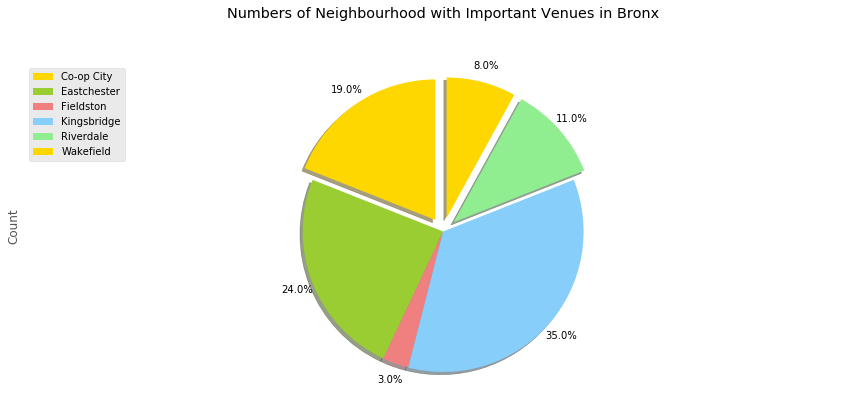

In [64]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen']
explode_list = [0.1, 0, 0, 0, 0.1, 0.1]
Bronx_Neighbourhoods['Count'].plot(kind='pie',
                            figsize=(15, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,       
                            pctdistance=1.12,   
                            colors=colors_list,
                            explode=explode_list 
                                  )

# scale the title up by 12% to match pctdistance
plt.title('Numbers of Neighbourhood with Important Venues in Bronx', y=1.12) 

plt.axis('equal') 

# add legend
plt.legend(labels=Bronx_Neighbourhoods['Neighborhood'], loc='upper left') 

plt.show()